__Optical Coherence Tomography: Clinical Applications__


Optical coherence tomography (OCT) is a techinque developed in 1991 for imaging retina, the photosensitive layer of the eye. It uses a non-invasive light beam and derives an image of the target tissue (e.g., retina, anterior chamber...etc.) using low-coherence interferometry to generate cross-sectional images in-vivo! There are many uses for OCT which revolve around inspecting abnormalities within these ocular tissues. For instance, the very high resolutions (of upto 5 microns from a Fourier Domain OCT) can be used to evaluate the integrity of anterior chamber, retinal thickness, neurosensory as well as blood capillary complexes (RPE-Choroid complex) in great detail. A few (from a long list of) tissue abnormalities that can be picked up by an OCT scan with high confidence include - 

a. Epiretinal membranes

b. Macular holes (Pseudo and otherwise)

c. Subretinal fluid

d. Neurosensory detachments

e. Pigment-epithelial detachments

f. Choroidal neovascular membranes (CNV)

g. Age Related Macular Disease related irregularities in RPE.

For a more detailed description, you can check out [this webpage](https://www.opsweb.org/page/RetinalOCT) hosted at Ophthalmic Photographer's Society.


__In the Current Dataset, we are going to inspect 4 classes of these Retinal OCT images__

We have a set of 84,495 images that include 4 groups of images in our current dataset.

1. Normal (label: NORMAL) - This class of data includes images of retina that show all the retinal layers intact, a clear vitreo-retinal interface, posterior hyaloid, normal foveal pit.

2. Choroidal Neovascularization (label: CNV) - CNV is a sign noted in exudative age-related macular degeneration (AMD) that typically involves an abnormal growth of new blood vessels (hence the name neovascularization) from the choroidal vasculature. In doing so, it threatens the patient's vision by obscuring and damaging the neurosensory retina.

3. Diabetic Macular (O)edema (label: DME) - DME is an accumulation of fluid (edema or known as 'swelling') involving the hydro-ionic homeostasis in the retinal blood barrier. This disruption is caused due to Diabetis and acts a marker in diagnosing diabetic retinal diseases.

4. Drusen (label: DRUSEN) - Drusen are yellow colored lipid deposits under the retina associated with Age related Macular Degeneration (AMD). There are various sizes and shapes of Drusens. However, in our dataset, we group them all under a single label.


__Please visit [this](https://www.reviewofoptometry.com/article/the-abcs-of-oct) useful resource if you would like to know more about OCT and its utility and the specific ways in which OCT of retinal images can be read or understood.__


![A side-by-side comparision of our classes](https://i.imgur.com/fSTeZMd.png)

@IMAGE COURTESY: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

The data is organized into 3 folders (train, test, and val), each with 4 subfolders representing our classes (NORMAL, CNV, DME, DRUSEN).

Each image is labeled as (class)-(randomID)-(imageIDfortherandomID).

__Our goal is to predict the class that each image belongs to (and therefore, the condition associated with the image) using neural nets that are optimized for speed if possible.__

__Let's inspect our data, preprocess it, balance our classes as needed, and then build some predictive models__ 

# Data Analysis Begins Here!

In [1]:
# Let's first import the paths to our data subsets (train, test, and validation subsets)

TRAIN_PATH='../Downloads/kermany2018/OCT2017_/train'
TEST_PATH='../Downloads/kermany2018/OCT2017_/test'
VAL_PATH='../Downloads/kermany2018/OCT2017_/val'

In [2]:
# let's use our gpu cores to run our models since it takes a significantly longer time with cpu power alone due to the size of our dataset
# skip this step if you do not have access to gpus in your machine or if you wish to use my code to run your models this in the cloud

# Let's check if there is a gpu on the system. Mine does, but i want to verify that tf has access to it.
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# Let's make sure that our tf is making use of cuda cores
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
print(tf.test.is_built_with_cuda())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18426290660231757127
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9210949796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5297724808668952855
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
True


Using TensorFlow backend.


Now that we have our data, let's investigate it further.

However, since the data is not available as a dataframe or in any easily accessible format, we will have to grab relevant information and store them in something easier to gather descriptive stats on.

# EXTRACT!

In [3]:
# Let's get all the relevant information necessary to examine our data and then visualize some of the key aspects of our data.
import numpy as np
import pandas as pd
import os
from PIL import Image

# Empty lists so we can read and add our data

categories = []
image_categories = []
number_train = []
number_test = []
number_valid = []
heights = []
widths = []

# Iterate through each category
for d in os.listdir(TRAIN_PATH):
    categories.append(d)

    # Number of images in training dataset
    train_imgs = os.listdir(TRAIN_PATH + '/'+ d)
    number_train.append(len(train_imgs))

    # Number of images in testing dataset
    test_imgs = os.listdir(TEST_PATH + '/'+ d)
    number_test.append(len(test_imgs))

    # Number of images in validation dataset
    valid_imgs = os.listdir(VAL_PATH + '/'+ d)
    number_valid.append(len(valid_imgs))

    # Find stats for train images
    for i in train_imgs:
        image_categories.append(d)
        img = Image.open(TRAIN_PATH + '/' + d + '/' + i)
        img_array = np.array(img)
        # Shape
        heights.append(img_array.shape[0])
        widths.append(img_array.shape[1])

# Alright now that we have our categories and the images in their own dataframes, let's inspect them
# Dataframe of categories
categories_df = pd.DataFrame({'category': categories,
                       'n_train': number_train,
                       'n_valid': number_valid, 'n_test': number_test}).\
    sort_values('category')

# Dataframe of training images
images_df = pd.DataFrame({
    'category': image_categories,
    'height': heights,
    'width': widths
})

categories_df.sort_values('category', ascending=False, inplace=True)

In [4]:
categories_df.head()

category  n_train  n_valid  n_test
3   NORMAL    26315        8     242
2   DRUSEN     8616        8     242
1      DME    11348        8     242
0      CNV    37205        8     242

In [4]:
# Let's inspect them visually to see if our classes are balanced.
import bokeh as bk
from bokeh.plotting import figure
from bokeh.plotting import *
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.palettes import Plasma
output_notebook()


%matplotlib inline
import matplotlib as mplc
from matplotlib import pyplot as plt
mplc.style.use('seaborn-bright')


category = categories_df.category.astype(str)
n_train = categories_df.n_train.astype(int)


p = figure(plot_width=800, plot_height=400, title='Training Images by Category',
           x_range=category, toolbar_location=None, tools="hover", tooltips="@category: @n_train")
index_cmap = factor_cmap('category', palette=Plasma[4], 
                         factors=sorted(category.unique()), end=1)
p.vbar(x='category', top='n_train', width=1, source=categories_df,
       line_color="white", fill_color=index_cmap, 
       hover_line_color="darkgrey", hover_fill_color=index_cmap, legend_field = "category")


p.xaxis.axis_label = "Category of the Retinal Image"
p.xaxis.major_label_orientation = 1.2
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"

show(p)




# If you would rather use sns/matplotlib, use the code below
# palette=['#d7191c', '#ffffbf', '#fdae61', '#abdda4']
# p = figure(width=800, height=400)
# categories_df.set_index('category')['n_train'].p.vbar(figsize=(20, 6), color = palette)

# # Setting the labels on top of each bar
# vals = [26315, 8616, 11348, 37205]
# for i, v in enumerate(vals):
#     p.text(i-0.07, v + 1000, str(v), color='black', text_align = 'center', text_font_style='bold')

# plt.show()
# plt.xticks(rotation=80)
# plt.ylabel('Count')
# plt.title('Training Images by Category')

Loading BokehJS ...

In [6]:
# We can also see that our image_df dataframe includes the category and corresponding height and width of each of our images.
images_df.head(10)

category  height  width
0      CNV     496    512
1      CNV     496    768
2      CNV     496   1536
3      CNV     496    512
4      CNV     496    512
5      CNV     496    512
6      CNV     496    512
7      CNV     496    512
8      CNV     496    512
9      CNV     496    512

In [5]:
images_description = images_df.groupby('category').describe()
images_description.head()

height                                                           \
            count        mean       std    min    25%    50%    75%    max   
category                                                                     
CNV       37205.0  496.000000  0.000000  496.0  496.0  496.0  496.0  496.0   
DME       11348.0  508.208671  6.803761  496.0  512.0  512.0  512.0  512.0   
DRUSEN     8616.0  496.000000  0.000000  496.0  496.0  496.0  496.0  496.0   
NORMAL    26315.0  500.132700  7.003275  496.0  496.0  496.0  512.0  512.0   

            width                                                              
            count        mean         std    min    25%    50%    75%     max  
category                                                                       
CNV       37205.0  736.372423  338.497157  384.0  512.0  512.0  768.0  1536.0  
DME       11348.0  564.788157  191.861512  512.0  512.0  512.0  512.0  1536.0  
DRUSEN     8616.0  670.692665  280.842588  512.0  512.0  512.0  768.0  1536.0  
NORMAL    26315.0  659.670606  288.606761  384.0  512.0  512.0  768.0  1536.0

Loading BokehJS ...

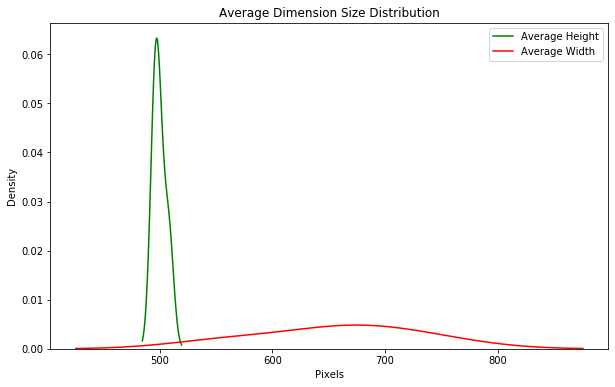

In [6]:
# Let's inspect the heights and widths of the images.
import bokeh
import seaborn as sns
# import mpld3
# from bokeh.layouts import gridplot
# from bokeh import mpl
# from bokeh.plotting import show
output_notebook()
plt.figure(figsize=(10, 6))
sns.kdeplot(images_description['height']['mean'], label='Average Height', color = 'g')
sns.kdeplot(images_description['width']['mean'], label='Average Width', color = 'r')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Dimension Size Distribution')
plt.show()
# mpld3.display()
# show(bokeh.mpl.to_bokeh(name="kde"))

In [7]:
# While the above graphic shows the range of pixel values for width and height, it might be misleading due to the continuous nature of the graphs being used.
# In reality, the extent of heights and widths are limited
# We can derive those by looking at the unique values of both columns
print(images_df.width.unique())
print(images_df.height.unique())

# We can also visualize them as below

p2 = figure(plot_width=800, plot_height=400, title='Images width and height spread')
#             toolbar_location=None, tools="hover", tooltips="@category: @height: @width")
p2.scatter(x=images_df['width'], y=images_df['height'], size = 14, color = 'orange', alpha =0.8)
show(p2)

[ 512  768 1536 1024  384]
[496 512]


We can see that the heights are not as diverse but the widhts have wider distribution!
Let's take a look at a few examples of each class to see how these differences show up as when we visually inspect our images.

(496, 512)


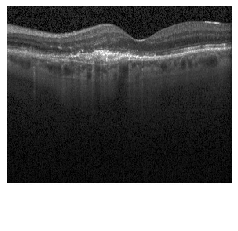

In [8]:
def imshow(image):
    """Display image"""
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
x = Image.open(TRAIN_PATH + '/CNV/CNV-5557306-155.jpeg')
print(np.array(x).shape)
imshow(x)

# If would rather use Bokeh, use this code instead
# from bokeh.models import Plot
# from bokeh.models.glyphs import ImageURL
# x = figure(x_range=(0,512), y_range=(0,512))
# x.image_url(url=['../Downloads/kermany2018/OCT2017_/train/CNV/CNV-5557306-155.jpeg'], x=512, y=512, w=512, h=512, anchor="top_left")
# x.add_glyph(source, image2)
# show(x)



(512, 512)


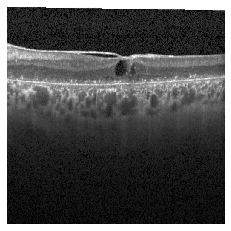

In [11]:
x = Image.open(TRAIN_PATH + '/DME/DME-4441781-1.jpeg')
print(np.array(x).shape)
imshow(x)

Ideally, all of our images are supposed to look like these two examples above. They should have a standard pixel width and height across all images for the learning to be fast and the predictions to be comparable.

However, based on our earlier analysis, we noticed that the widths were widely different across our images.

Let's take a look at a few examples.


#### Let's take a look at the first 25 images in each of the classes within the test forlder.

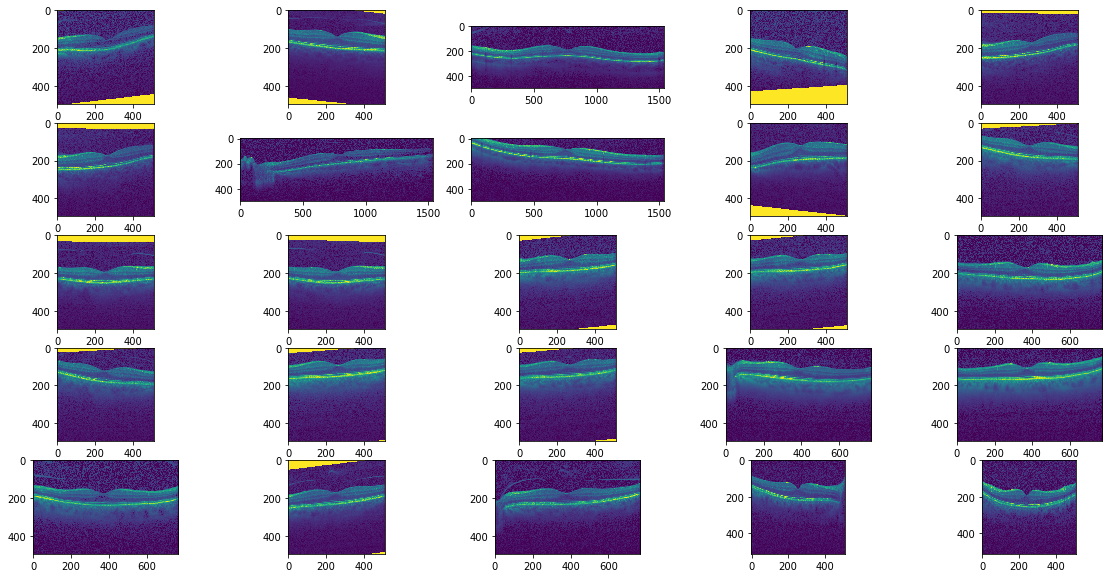

In [12]:
import glob
import matplotlib.image as mpimg
imagesTrainNORMAL = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/NORMAL/*.jpeg'):
    imagesTrainNORMAL.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
columns = 5
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainNORMAL[i])

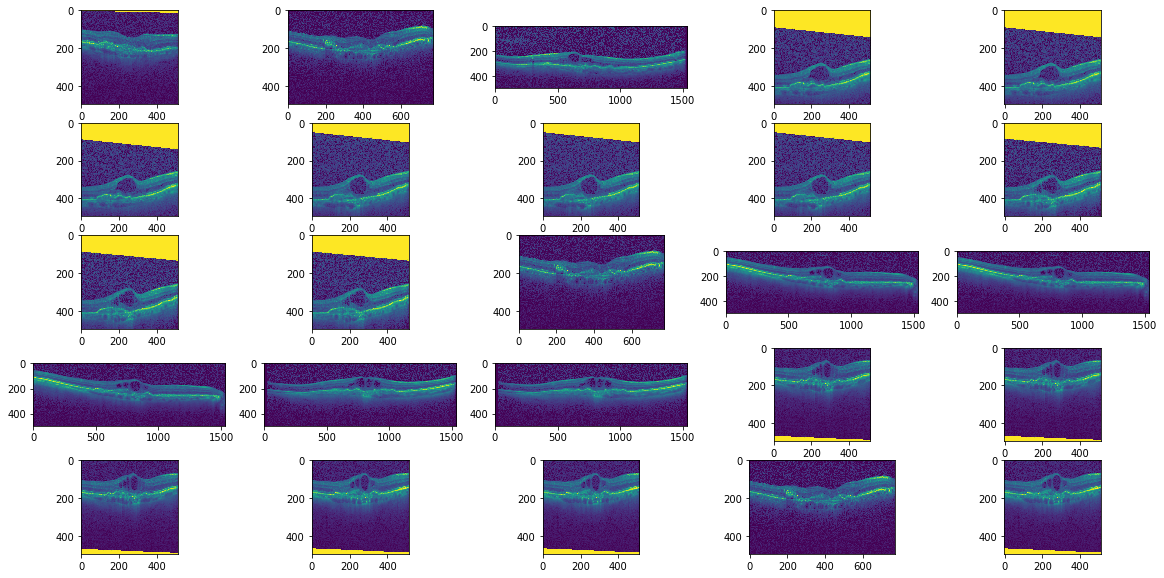

In [7]:
imagesTrainCNV = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/CNV/*.jpeg'):
    imagesTrainCNV.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainCNV[i])

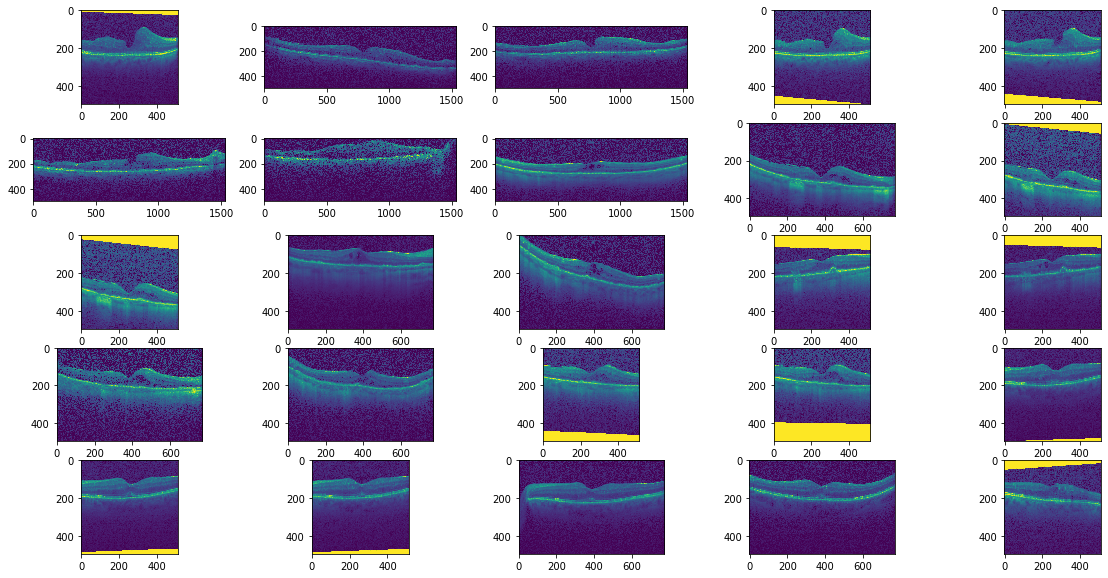

In [6]:
imagesTrainDME = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/DME/*.jpeg'):
    imagesTrainDME.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainDME[i])

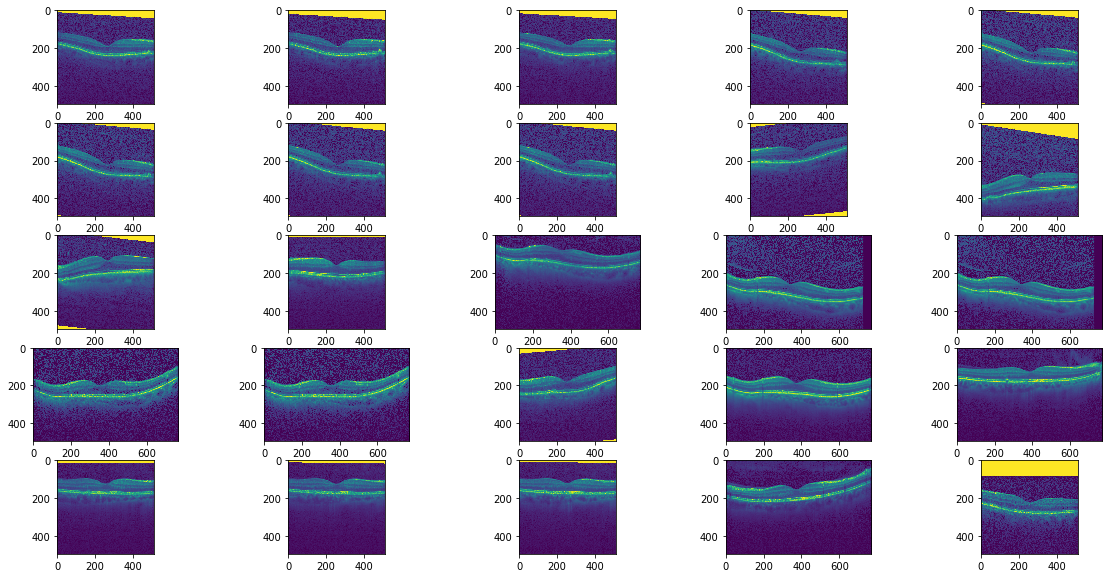

In [7]:
imagesTrainDRUSEN = []
for img_path in glob.glob('../Downloads/kermany2018/OCT2017_/train/DRUSEN/*.jpeg'):
    imagesTrainDRUSEN.append(mpimg.imread(img_path))
plt.figure(figsize=(20,10))
for i in range(0, 25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imagesTrainDRUSEN[i])

We can see that images are not well aligned and sometimes not even the same size. Thus, we have to ensure that the images are a fixed size and are filtered before we can analyze them any further.

##### Let's make use of our some pretrained models to do our analysis. We will have to transform all our images to match the required sizes of the pretrained models. In our case, pretrained models like vgg16, resnet50, and mobilenet require a size of 224x224. Inception might need a 299x299.

In [13]:
# We could import the pretrained models like so, but I will save it for later so we can run our own model to see how we are doing.

# import keras
# from keras.applications import vgg16, inception_v3, resnet50, mobilenet

In [9]:
# Let's import some basic dependencies out of the way before we import the ones specific to our modeling efforts
import os
import gc
import re
import operator 

##### Let's import all the modeling dependencies. Mostly pertaining to Keras workflow with Tensorflow 2.0 backend.

In [10]:
import imageio as im
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import itertools

# TRANSFORM & LOAD!

Let's use the image data generator method in keras to preprocess and add images from all of our folders to the respective datasets. [Here is a handy tutorial if you need a primer.](https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92)

In [11]:
# Let's use the ImageDataGenerator to reinforce our datasets and fix the size of the data at 224x224 to match the requirements of our data

train_batches = ImageDataGenerator(rescale = 1/255, zca_whitening = True, vertical_flip = True, horizontal_flip = True).flow_from_directory(TRAIN_PATH, target_size=(224,224), class_mode='categorical', batch_size=64)
valid_batches = ImageDataGenerator(rescale = 1/255).flow_from_directory(VAL_PATH, target_size=(224,224), class_mode='categorical', batch_size=64)
test_batches = ImageDataGenerator(rescale = 1/255).flow_from_directory(TEST_PATH, target_size=(224,224), class_mode='categorical', batch_size=64)
print('Batches train=%d, valid = %d, test=%d' % (len(train_batches), len(valid_batches), len(test_batches)))

# print('Train', (train_batches.shape))
# print('Test', (test_batches.shape, test_labels.shape))
# print('Validation', (valid_batches.shape, train_labels.shape))

C:\Users\Shaf\AppData\Roaming\Python\Python36\site-packages\keras_preprocessing\image\image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Batches train=1305, valid = 1, test=16


Now that we have all of our images in the format that we want, we can start building the models.

# **Creating model**

### Now that we have all of our necessary dependencies for building a model, let's start with a simple 6-layered convolution model that takes our inputs from earlier and returns a fully connected layer with softmax activation.

##### Let's build a shallow neural net to train our model first and then later, build a deep neural net with one of the four pretrained models

In [12]:
# Let's fix our outputs and input sizes
# out,ins=create_model(in_shape=(224,224,3),pool_size=(2,2),kernal_size=(3,3))
#  Let's build a shallow neural net first with 6 convolutional layers
	
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# compile the model;
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

__Let's create an early stopping callback that stops the model early if it meets the specified critieria.__

In [13]:
import datetime
log_dir="C:\\Users\\Shaf\\logs_retinalimages" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, 
                         mode='auto', baseline=None, restore_best_weights=False)

import warnings
warnings.filterwarnings("ignore")

# **Running the model**

Now that we have everything set and ready, let's call on our model and see how well it's doing.

In [19]:
history = model.fit_generator(train_batches, steps_per_epoch=2000, epochs=5, shuffle=True, 
                              validation_data = valid_batches, validation_steps = 968, 
                              callbacks = [tensorboard_callback, early_stop])
_, acc = model.evaluate_generator(test_batches, steps=1000, verbose=0)
print(tensorboard_callback)
print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/5
2000/2000 [==============================] - 1290s 645ms/step - loss: 0.6890 - accuracy: 0.7403 - val_loss: 0.3565 - val_accuracy: 0.8750
Epoch 2/5
2000/2000 [==============================] - 1313s 656ms/step - loss: 0.3941 - accuracy: 0.8614 - val_loss: 0.1519 - val_accuracy: 0.9688
Epoch 3/5
2000/2000 [==============================] - 1362s 681ms/step - loss: 0.3320 - accuracy: 0.8854 - val_loss: 0.1507 - val_accuracy: 0.9375
Epoch 4/5
2000/2000 [==============================] - 1239s 620ms/step - loss: 0.3065 - accuracy: 0.8944 - val_loss: 0.0874 - val_accuracy: 0.9688
Epoch 5/5
2000/2000 [==============================] - 1262s 631ms/step - loss: 0.2897 - accuracy: 0.9007 - val_loss: 0.0623 - val_accuracy: 1.0000
Test Accuracy: 97.834


In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir r"C:\Users\Shaf\logs_retinalimages20191114-140829"

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 28076.

In [22]:
# Let's take a look at our model summary!
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

**Taking a sample image. The very first image in test folder under DME class.**

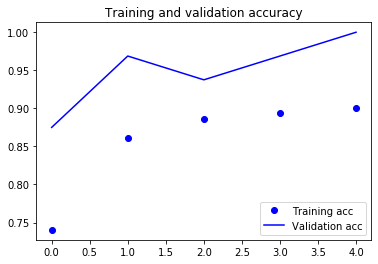

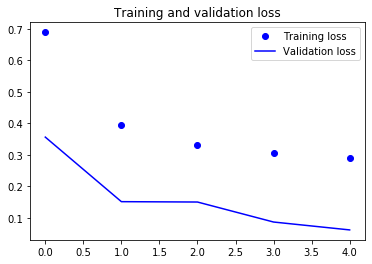

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels
'''
# For reference, these were out initial paths
TRAIN_PATH='../Downloads/kermany2018/OCT2017_/train'
TEST_PATH='../Downloads/kermany2018/OCT2017_/test'
VAL_PATH='../Downloads/kermany2018/OCT2017_/val'

'''

"\n# For reference, these were out initial paths\nTRAIN_PATH='../Downloads/kermany2018/OCT2017_/train'\nTEST_PATH='../Downloads/kermany2018/OCT2017_/test'\nVAL_PATH='../Downloads/kermany2018/OCT2017_/val'\n\n"

In [33]:
# train_features, train_labels = extract_features(TRAIN_PATH, 2000)
# validation_features, validation_labels = extract_features(VAL_PATH, 8)
test_features, test_labels = extract_features(TEST_PATH, 968)

filenames = test_batches.filenames

true_class = test_batches.classes
 
predicted_class = test_batches.class_indices

test_features = np.reshape(test_features, (968, 4 * 4 * 512))

import iteritems
# Getting the mapping from class index to class label
index2label = dict((v,k) for k,v in predicted_class.iteritems())
 
predictions = model.predict_classes(test_features)
prob = model.predict(test_features)
 
errors = np.where(predictions != true_class)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

Found 968 images belonging to 4 classes.


ValueError: could not broadcast input array from shape (32,4) into shape (32,4,4,512)

(512, 512)


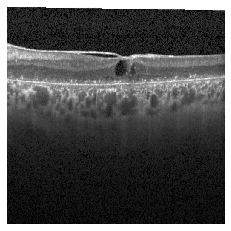

262144


In [27]:
test_image = Image.open(TRAIN_PATH + '/DME/DME-4441781-1.jpeg')
# Let's convert our image from a 2d image to a 3d image.
# But first, we have to convert our image to an array
print(np.array(test_image).shape)
imshow(test_image)
test_image=image.img_to_array(test_image)
print(test_image.size)

In [41]:
#VISUAL ANALYSIS    
from keras.preprocessing import image    
im1_path="../Downloads/kermany2018/OCT2017_/test/NORMAL/NORMAL-1025847-1.jpeg"
test_image=image.load_img(im1_path,target_size=(224,224))
# test_image = tf.image.decode_jpeg(test_image)
# test_image = tf.cast(test_image, tf.float32)

In [42]:
# Once we convert our image to an array, we can expand dimensions using the following code
test_image= np.expand_dims(test_image,axis=0)

In [43]:
# We have 4 classes in our data. Let's get the indices for them.
train_batches.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [44]:
# Now, let's see how well our predictive model is doing on our test_image. Remember that we grabbed this image from our "NORMAL" folder, so we should see 3 as our output.
result=np.argmax(model.predict(test_image))
print(result)

TypeError: Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64

GREAT! Our model was able to identify the normal image as a normal image! Given that our model's accuracy is around 90%, we should expect good results for most test cases. But we do not yet know how well our model is doing on our test dataset. Let's work on our model to get this information.

**Before we get the final predictions on our test dataset, let's take a look at the intermediary steps of our model. This will allow us to see what is going on within our convolutional layers and how the filerting is changing our images.**

In [45]:
# Let's write a function that looks at our filters and biases and append them to their respective lists.
def get_name_layer_filters(model):
    filter_whole=[]
    layer_whole=[]
    for layer in model.layers:
        if 'conv' not in layer.name:
            continue
        filters,biases=layer.get_weights()
        filter_whole.append(filters)
        layer_whole.append(biases)
        print(layer.name,filters.shape)
    return filter_whole,layer_whole    
        

**Now Let's use the model we built to output the filters and biases.**

In [46]:
filter_whole,layer_whole=get_name_layer_filters(model)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 32)
conv2d_2 (3, 3, 32, 64)
conv2d_3 (3, 3, 64, 64)
conv2d_4 (3, 3, 64, 128)
conv2d_5 (3, 3, 128, 128)


**Now let's focus on our layer 1 and get the weights assigned to this layer.**

In [58]:
# Getting filters and biases from layer1
filters,biases=model.layers[1].get_weights()
# model.layers[2].output

AttributeError: 'Sequential' object has no attribute 'layer'

**Normalizing the filters**

In [52]:
# and then normalizing our filters with a minmax approach
f_min,f_max=filters.min(),filters.max()
filters=(filters-f_min)/(f_max-f_min)

NameError: name 'filters' is not defined

**Plotting the filters**

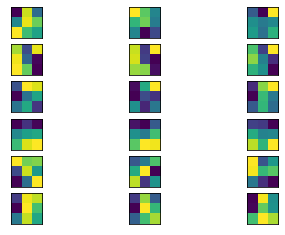

In [29]:
# Let's inspect our filters visually!
from matplotlib import pyplot
n_filters,ix=6,1
for i in range(n_filters):
    f=filters[:,:,:,i]
    #Plot each channel
    for j in range(3):
        ax=pyplot.subplot(n_filters,3,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        #Plot filter channel
        pyplot.imshow(f[:,:,j])
        ix+=1
        
pyplot.show()    

**Starting with the plotting**

**Making a model from feature map.We will start with making a model with outputs from 1st convolution layer of model and input from model.**


In [30]:
#FEATURE MAP
model_feature=Model(inputs=model.inputs,outputs=model.layers[4].output)

**Using previous model to predict test_image**

In [31]:
#We use result from previous
feature_map=model_feature.predict(test_image)


In [32]:
feature_map.shape

(1, 125, 125, 64)

**Plot feature maps**

32 feature maps will be plotted. We will try to analyze these maps and interpret them in a useful way after plotting them.

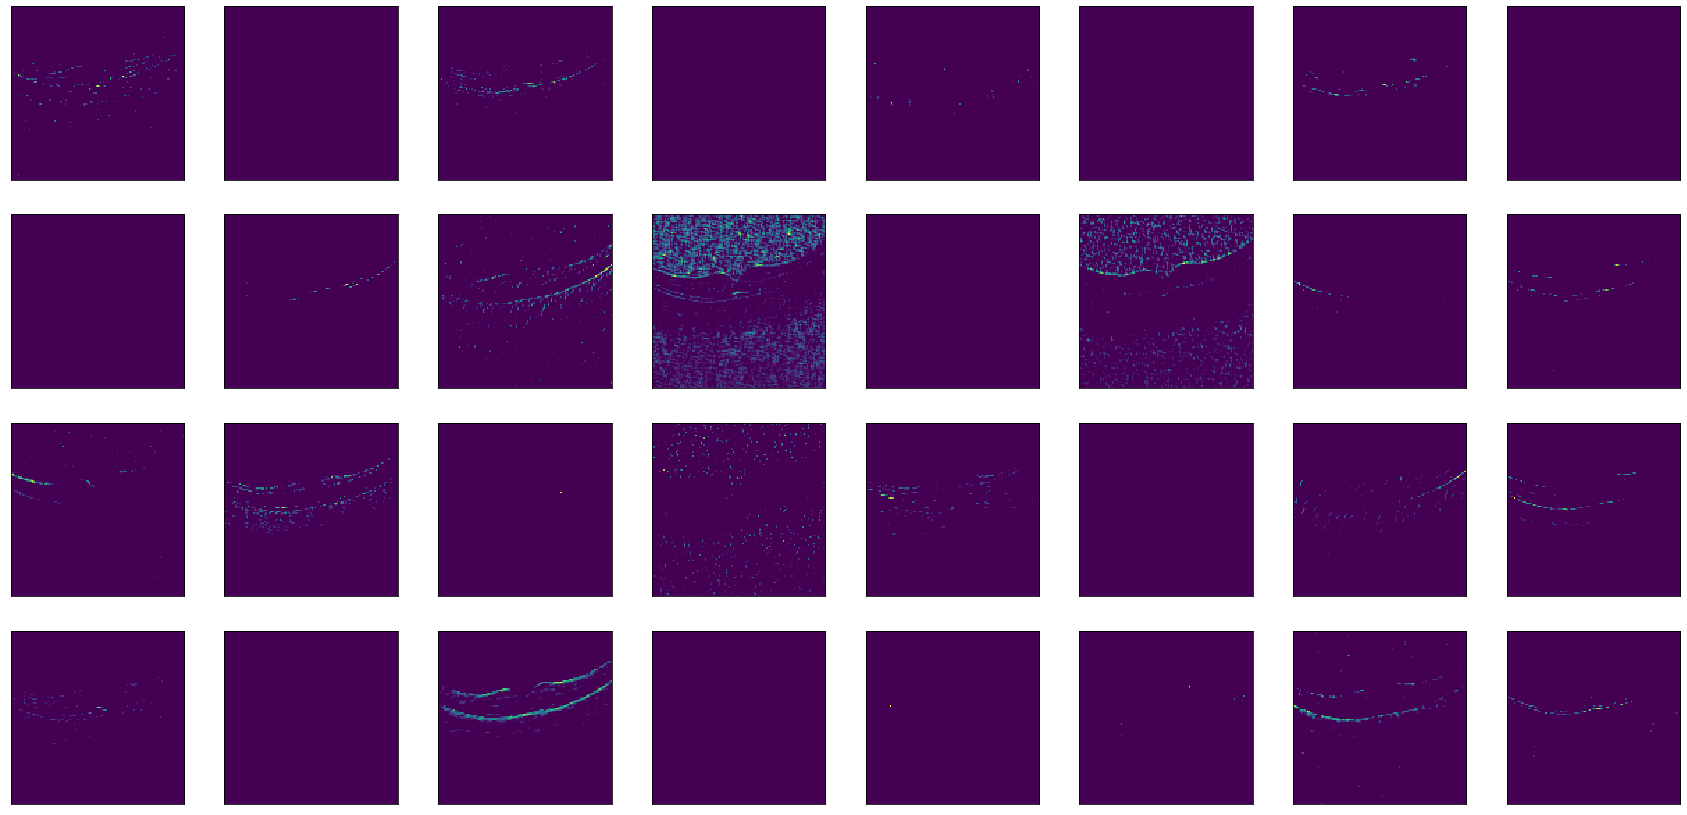

In [33]:
#plot all 32 maps in an 8*4 squares
pyplot.figure(figsize=(30,30))        
        
square=8
ix=1
for _ in range(4):
    for _ in range(8):
        ax=pyplot.subplot(square,square,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        pyplot.imshow(feature_map[0,:,:,ix-1])
        ix+=1
        
pyplot.show()

**We can well observe that our model in its first convolutional layer is trying to detect features as evident from feature maps above.We can even observe edge detections as observed in the subplot(2,5).The model tries to detect the image and is studying its features. Some of these features can be easily seen by human eye. Higher the convoluional layers finer these detections become as becomes evident when we further plot next convolutional layers.**


**Now implementing above feature map plotting for all convolution layer.**

**This function returns models from all convolutional layers in our model**

In [34]:
def get_convolutional_layers(model):
    convolutions_models=[]
    for layer in model.layers:
        if 'conv2d' not in layer.name:
            continue
        model_temp=Model(inputs=model.inputs,outputs=layer.output)
        convolutions_models.append(model_temp)
    return convolutions_models    
        
        

**This function returns feature maps and models list**

In [35]:
#To see each feature map systematically for every convolutional layer
def generate_feature_maps(model,test_image):
    models=get_convolutional_layers(model)#Fetching convolution layers models
    feature_maps=[]
    
    for model_temp in models:
        feature_map=model_feature.predict(test_image)
        feature_maps.append(feature_map)
    return feature_maps,models    


**This function plots 32 feature maps.**

In [36]:
def plot_graph(feature_map):
    
    #plot all 32 maps in an 8*4 squares
    pyplot.figure(figsize=(30,30))        
        
    square=8
    ix=1
    for _ in range(4):
        for _ in range(8):
            ax=pyplot.subplot(square,square,ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_map[0,:,:,ix-1])
            ix+=1
        
    pyplot.show()

**Generating plots and showing original image.**

In [37]:
def plots_generator(model):
    print("IMAGE UNDER CONSIDERATION")
    test_image=image.load_img(im1_path,target_size=(256,256))
    plt.imshow(test_image)
    test_image=image.img_to_array(test_image)

    test_image= np.expand_dims(test_image,axis=0)
    print()
    feature_maps,models=generate_feature_maps(model,test_image)
    #ax=pyplot.subplot(square,square,ix)# only 32 filters will be shown of each layer
    counter=1
    for each_map in feature_maps:
        print("Convolutional Layer Number {} ".format(counter))
        counter+=1
        #ax=pyplot.subplot(square,square,ix)
        plot_graph(each_map)


**Function to start with plotting feature maps.**

IMAGE UNDER CONSIDERATION

Convolutional Layer Number 1 


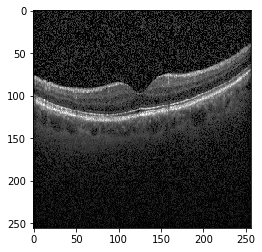

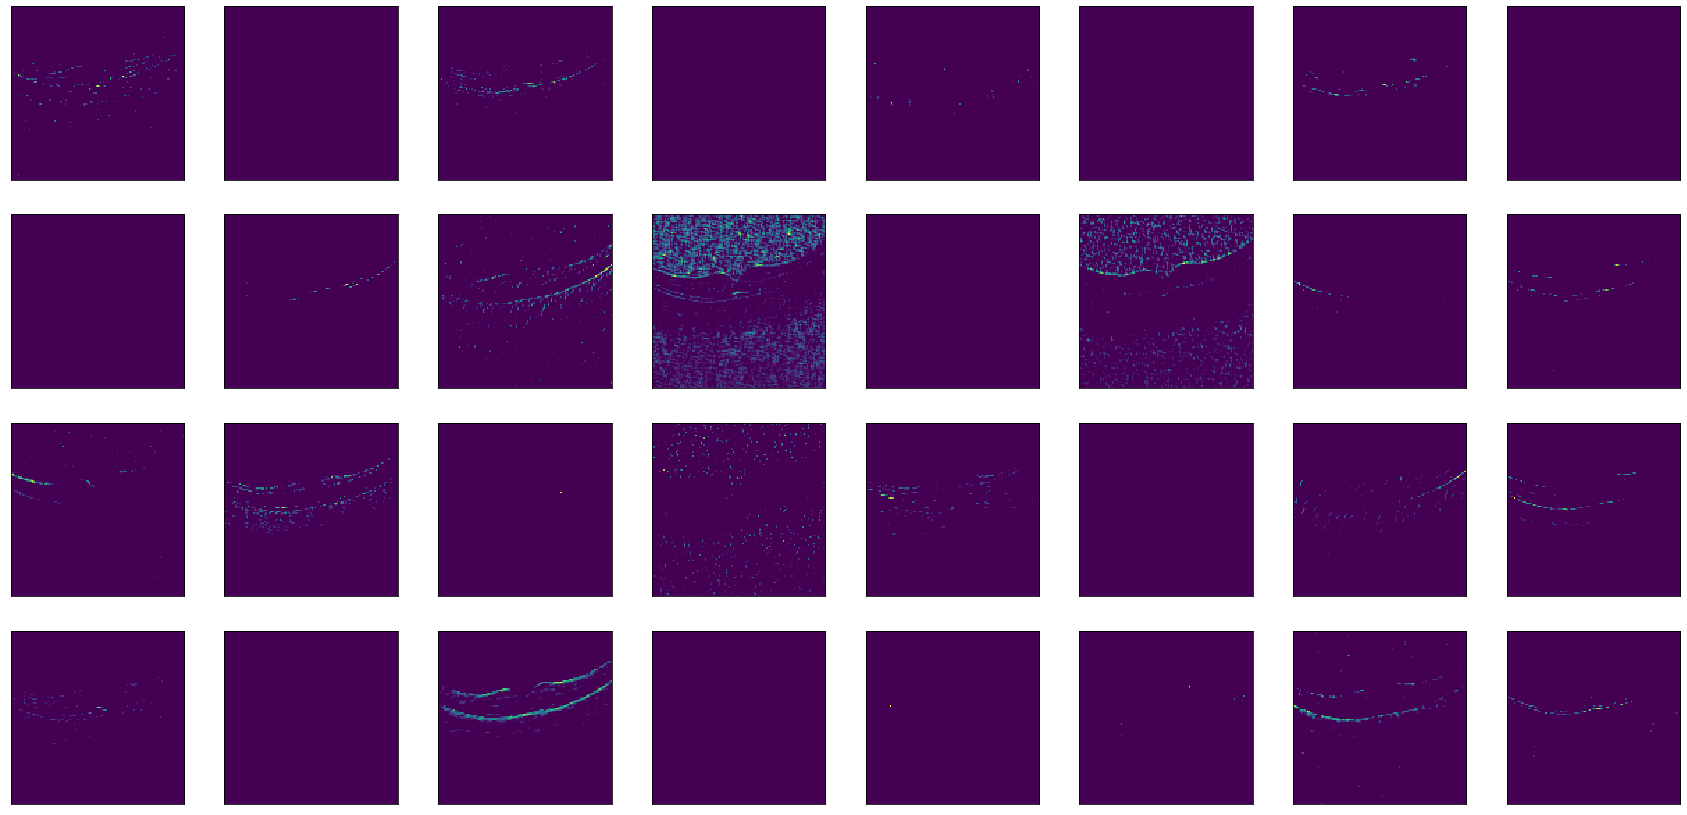

Convolutional Layer Number 2 


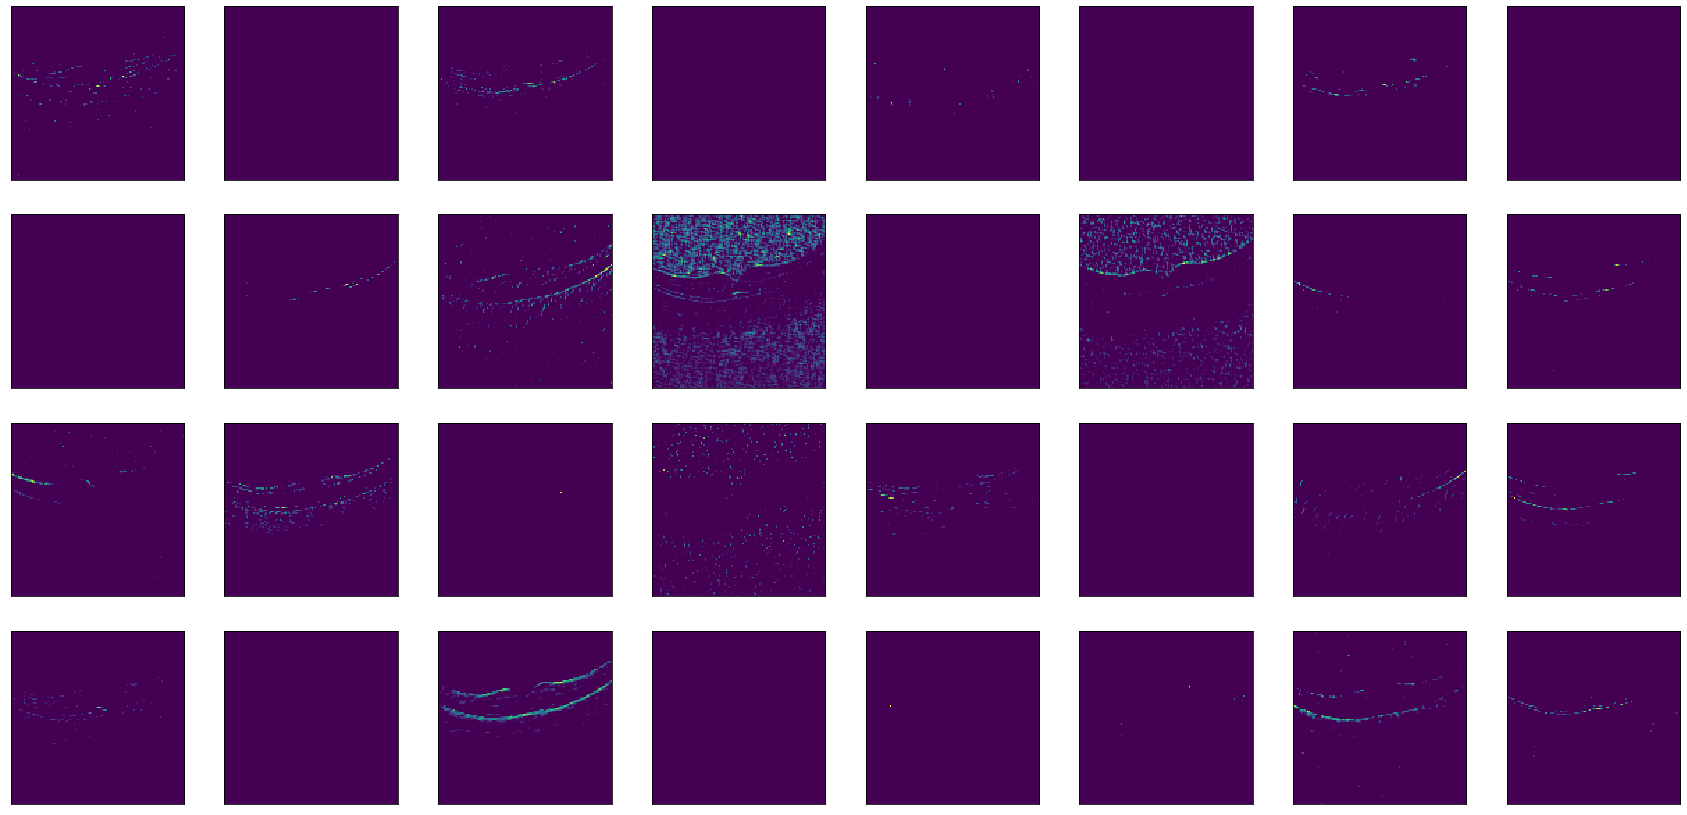

Convolutional Layer Number 3 


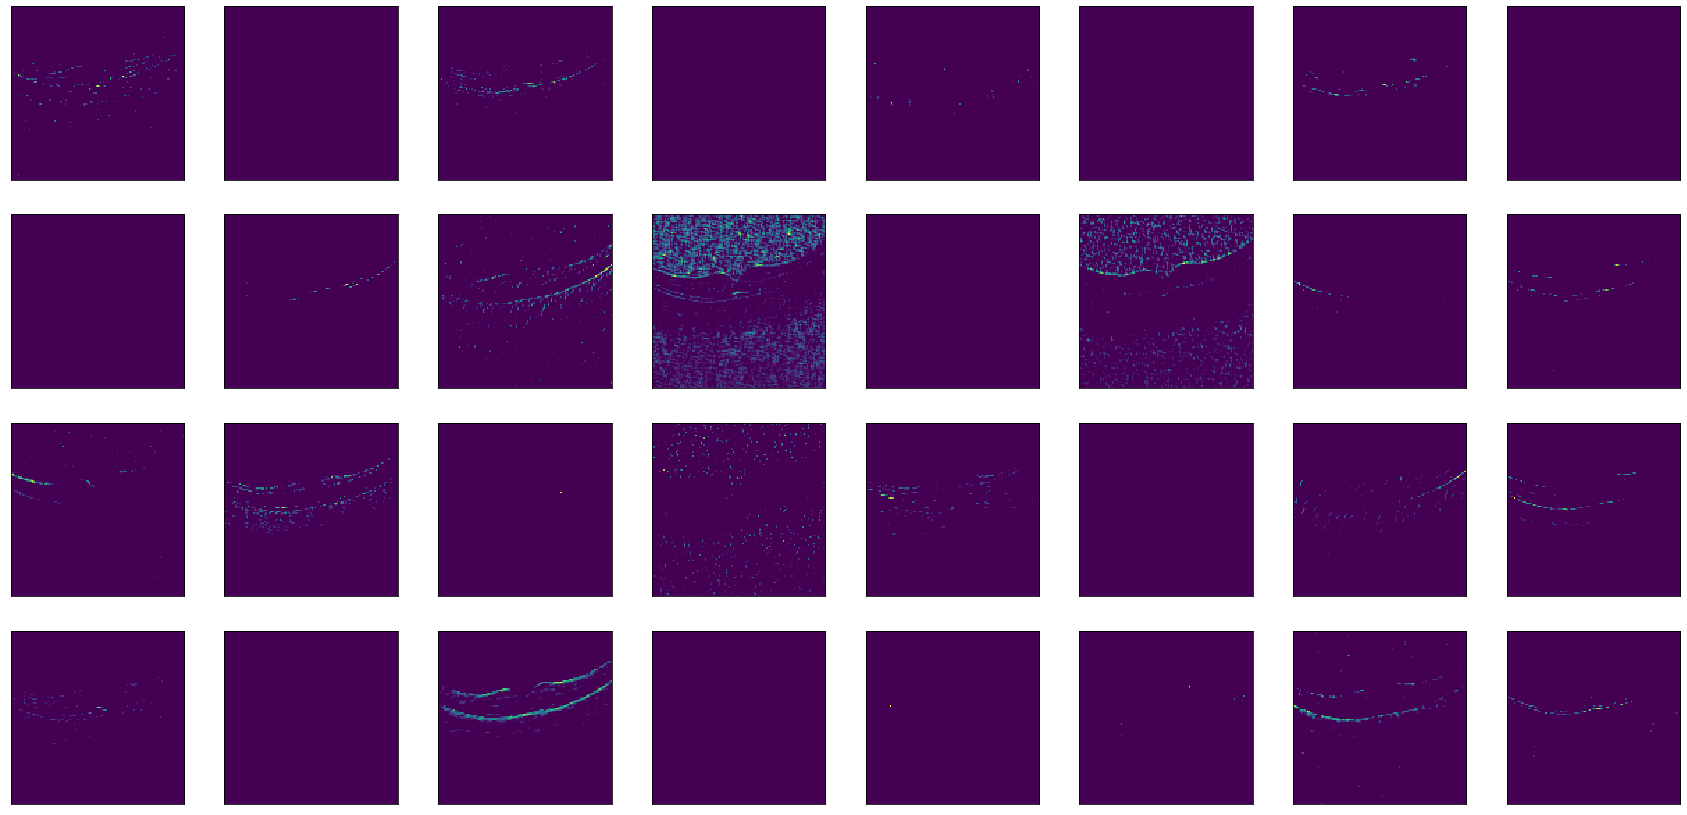

Convolutional Layer Number 4 


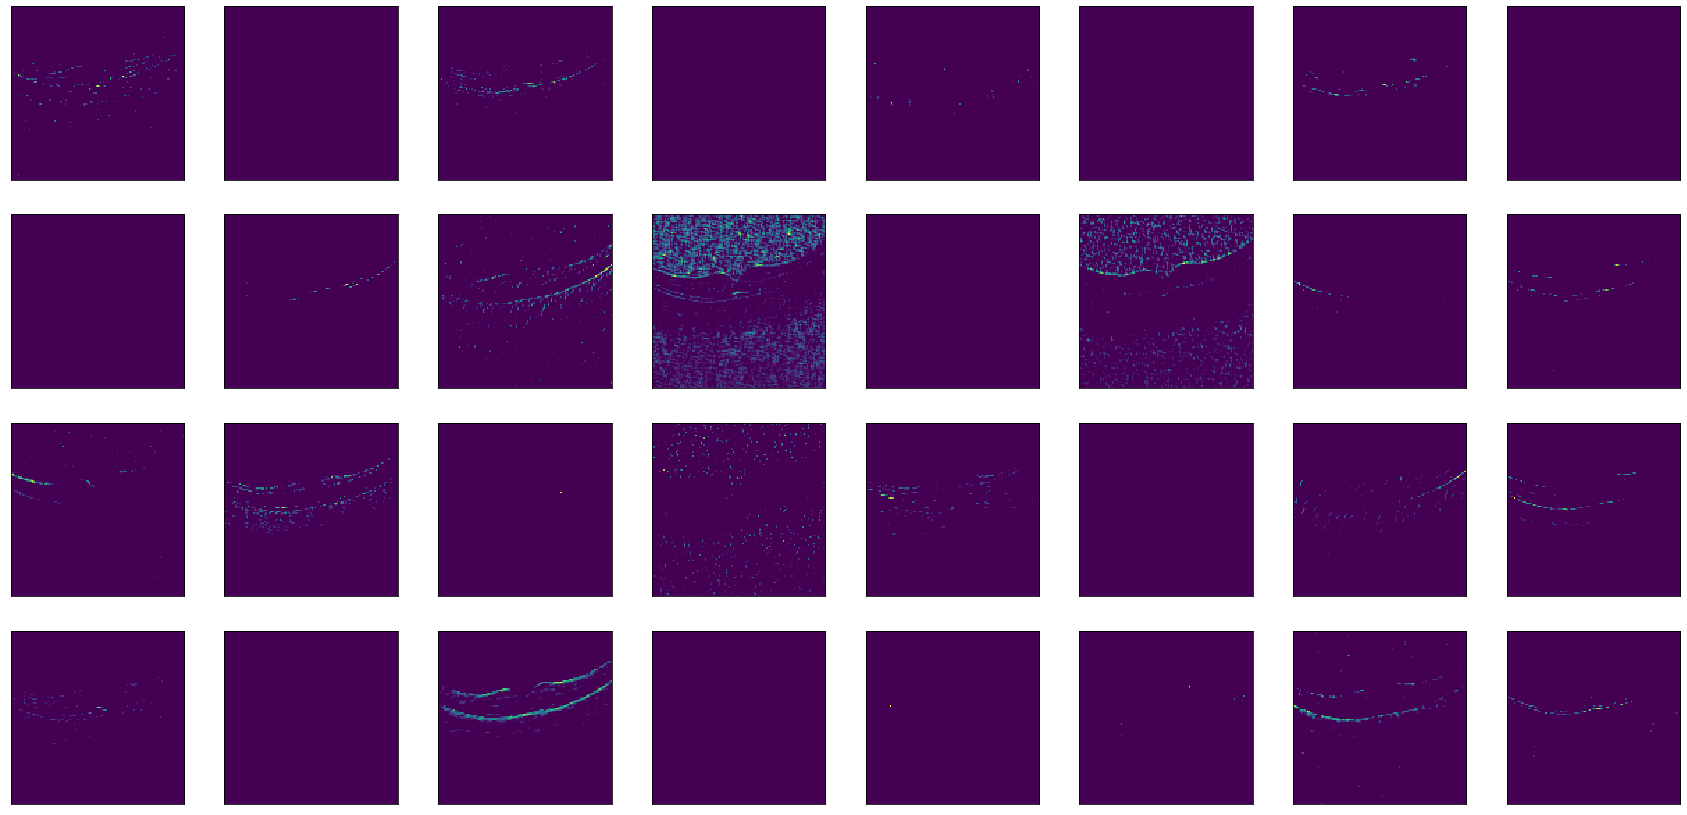

In [38]:

plots_generator(model)

**Now as we can observe as we move into deeper convolutional layers features get more refined and clearer. We can also add up custom filters which may lead to better feature detection, however let's keep it for our next kernel.**

In [40]:
hist.history['val_accuracy']

[0.5899708867073059,
 0.598868727684021,
 0.8218774795532227,
 0.8872717618942261,
 0.8687102794647217,
 0.9143622517585754,
 0.9310333132743835,
 0.9183646440505981,
 0.9328323602676392,
 0.9274278879165649]

**Checking Validation accuracies**

In [46]:
def val_acc_plot():
    print("FOR MODEL VALIDATION DATA")
    plt.plot(hist.epoch,hist.history['val_accuracy'])
    plt.xlabel("EPOCHS")
    plt.ylabel("Validation Accuracy")
    

In [53]:
def generate_images(all_paths):
    test_images=[]
    interpret=train_generator.class_indices
    test_y=[]
    
    for path in all_paths:
        y=''
        if 'DME' in path:
            y='DME'
        elif 'DRUSEN' in path:   
            y='DRUSEN'
        elif 'CNV' in path:   
            y='CNV'
        elif 'NORMAL' in path:   
            y='NORMAL'    
        
        for image_path in os.listdir(path):
            new_path=os.path.join('../Downloads/kermany2018/OCT2017_/test',y)
            #print(new_path)
            
            new_path=os.path.join(new_path,image_path)
            if 'Store' in str(new_path):
                continue
            temp_images=image.load_img(new_path,target_size=(256,256))
            temp_images=image.img_to_array(temp_images)
            test_images.append(temp_images)
            test_y.append(interpret[y])
    return test_images,test_y        


In [54]:
def generate_predictions(test_images,model):
    predictions=np.argmax(model.predict(test_images),axis=1)
    return predictions
    

In [55]:
from sklearn import metrics

def convert_data(model):
    # Now testing all test images to find test set accuracy.
    #We first need to put all test images and convert them in desired format to predict
    #Firstly we store path of test directory
    PATH_TEST=r"../Downloads/kermany2018/OCT2017_/test"
    all_paths=[]
    print("GENERATING PATHS")
    for directory in os.listdir(PATH_TEST):
        if 'Store' in directory:
            continue
        all_paths.append(os.path.join(PATH_TEST,directory))
    
    test_images,test_y=generate_images(all_paths)
    print("PATH GENERATED")
    test_images=np.array(test_images)
    print("GENERATING PREDICTIONS")
    predictions=generate_predictions(test_images,model)
    print("PREDICTIONS GENERATED")
    print()
    print("ACCURACY OF MODEL FOR TEST DATA IS {}".format(metrics.accuracy_score(test_y, predictions)))
    
    


In [56]:
convert_data(model)

GENERATING PATHS
PATH GENERATED
GENERATING PREDICTIONS
PREDICTIONS GENERATED

ACCURACY OF MODEL FOR TEST DATA IS 0.84400826446281


In [58]:
# Let's save this model so we can refine it later!

# serialize model to JSON
model_json = model.to_json()
with open("modelRetOCT.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelRetOCT.h5")
print("Saved model to disk")
 

Saved model to disk


In [59]:
'''
# later... when we need to use our model we can run the following code
 
# load json and create model
json_file = open('modelRetOCT.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelRetOCT.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

'''

'\n# later... when we need to use our model we can run the following code\n \n# load json and create model\njson_file = open(\'modelRetOCT.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("modelRetOCT.h5")\nprint("Loaded model from disk")\n \n# evaluate loaded model on test data\nloaded_model.compile(loss=\'binary_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nscore = loaded_model.evaluate(X, Y, verbose=0)\nprint("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))\n\n'

In [60]:
model.save("modelRetinalOCT.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
'''
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('modelRetinalOCT.h5')
# summarize model.
model.summary()
# load dataset
dataset = loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# evaluate the model
score = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
'''

### I will use pretrained models such as vgg16, inception_v3, resnet50, mobilenet to improve on this base model.
There are several steps to take before we can accomplish that.

First, we need to make sure that the size of each of our images are equal to the ones in pretrained models. 

Next, we need to freeze the weights of the first few layers and instead use the weights from the pretrained models.

In [14]:
# I will use pretrained models such as vgg16, inception_v3, resnet50, mobilenet to improve on this base model.
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')

#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

In [15]:
# Change to fit hardware
batch_size = 128

# Image manipulations
from PIL import Image
# Useful for examining network
# Timing utility
from timeit import default_timer as timer

# Visualizations

# In case you skipped everything else and wanted to use pretrained models make sure to import dependencies.
# import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['font.size'] = 14

In [16]:
# Let's try vgg16 first with weights from imagenet

# Let's also avoid the last 2 fully connected layers which are used to derive the classficiation

model_withpretrained = tf.keras.Sequential()

model = keras.Sequential()
model.add(vgg_model.layers[0])

conv_vgg16_base = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top = False, input_shape=(224,224,3))

In [17]:
conv_vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
model_withpretrained.add(conv_vgg16_base)
model_withpretrained.add(Flatten())
model_withpretrained.add(Dense(256, activation='relu'))
model_withpretrained.add(Dense(4, activation = 'softmax'))

In [19]:
from tensorflow.keras import optimizers

model_withpretrained.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

historyvgg16 = model_withpretrained.fit_generator(train_batches, steps_per_epoch=2000, epochs=5, shuffle=True, 
                              validation_data = valid_batches, validation_steps = 968, 
                              callbacks = [tensorboard_callback, early_stop])
_, acc = model_withpretrained.evaluate_generator(test_batches, steps=1000, verbose=0)
print(tensorboard_callback)
print('Test Accuracy: %.3f' % (acc * 100))

Epoch 1/5
2000/2000 [==============================] - 1922s 961ms/step - loss: 0.1049 - acc: 0.9622 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 2/5
2000/2000 [==============================] - 1907s 954ms/step - loss: 0.0682 - acc: 0.9767 - val_loss: 0.0111 - val_acc: 1.0000
Epoch 3/5
2000/2000 [==============================] - 1905s 952ms/step - loss: 0.0639 - acc: 0.9786 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 4/5
2000/2000 [==============================] - 1794s 897ms/step - loss: 0.0666 - acc: 0.9780 - val_loss: 0.0385 - val_acc: 0.9844
Epoch 5/5
2000/2000 [==============================] - 1777s 888ms/step - loss: 0.0690 - acc: 0.9777 - val_loss: 0.0359 - val_acc: 1.0000
Test Accuracy: 99.148


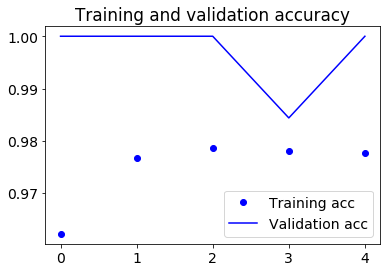

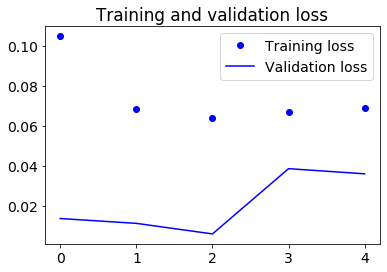

In [20]:
acc = historyvgg16.history['acc']
val_acc = historyvgg16.history['val_acc']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model.save('RetinalOCT_VGG16.h5')